In [ ]:
!pip install -q transformers datasets pillow torch
!pip install evaluate rouge_score
!pip install git+https://github.com/salaniz/pycocoevalcap.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

<h3><b>Importing the required libraries

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from datasets import load_dataset
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

<h3><b>Loading the dataset from huggingface

In [ ]:
dataset = load_dataset("reach-vb/pokemon-blip-captions")
dataset

README.md:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

(…)-00000-of-00001-566cc9b19d7203f8.parquet:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

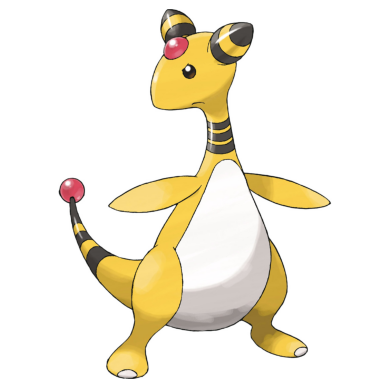

Caption: a yellow and white cartoon character with a red eye


In [ ]:
first = dataset["train"][100]
img = first["image"]
text = first["text"]
plt.imshow(img)
plt.axis("off")
plt.show()
print("Caption:", text)

<h3><b>Cleaning the data (dropping the rows which contain "pokemon type" more than once)

In [ ]:
def filter_pokemon_type(example):
    count = example["text"].lower().count("pokemon type")
    return count <= 1  #Removing all rows where pokemon type occurs more than once.
dataset = dataset.filter(filter_pokemon_type)
dataset = dataset.filter(lambda x: x["image"] is not None and x["text"] and len(x["text"].split()) >= 5)

Filter:   0%|          | 0/833 [00:00<?, ? examples/s]

Filter:   0%|          | 0/829 [00:00<?, ? examples/s]

<h3><b>After cleaning the dataset(4 rows dropped)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 829
    })
})

<h3><b>Splitting the data into train and test

In [ ]:
dataset = dataset["train"].train_test_split(test_size=0.15)
train_data = dataset["train"]
val_data = dataset["test"]

In [ ]:
train_data

Dataset({
    features: ['image', 'text'],
    num_rows: 704
})

In [ ]:
val_data

Dataset({
    features: ['image', 'text'],
    num_rows: 125
})

<h3><b>Printing a row from validation test(we will test the inference on this)

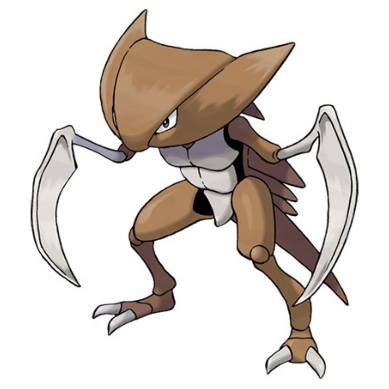

Caption: a drawing of a cartoon character holding a knife


In [ ]:
first = dataset["test"][100]
img = first["image"]
text = first["text"]
plt.imshow(img)
plt.axis("off")
plt.show()
print("Caption:", text)

<h3><b>Applying image augmentations to the images

In [ ]:
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAffine(5, shear=10),
])

<h3><b>Creating a custom class Captioning for processing images and text

In [ ]:
class Captioning(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(item["image"]).convert("RGB") if not isinstance(item["image"], Image.Image) else item["image"]

        # Process inputs
        inputs = self.processor(
            images=data_transforms(image),
            text=item["text"],
            padding="max_length",
            max_length=128,
            truncation=True,
            return_tensors="pt"
        )

        # Create labels
        labels = inputs["input_ids"].squeeze().clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": inputs["pixel_values"].squeeze(),
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

In [ ]:
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)

<h3><b>Creating training and validation datasets using the Captioning Class.

In [ ]:
train_dataset = Captioning(train_data, processor)
val_dataset = Captioning(val_data, processor)

In [ ]:
training_args = TrainingArguments(
    output_dir="./blip-finetuned-colab100",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=10,
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=50,
    learning_rate=2e-6,
    warmup_steps=50,
    save_steps=200,
    fp16=True,
    remove_unused_columns=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

<h3><b>Implementing early stopping if the model overfits

In [ ]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback]
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
50,1.331900,1.033213
100,0.944400,0.837772
150,0.769000,0.738940
200,0.692200,0.729593
250,0.642400,0.715135
300,0.599900,0.722531
350,0.574400,0.680787
400,0.559100,0.703096


Could not locate the best model at ./blip-finetuned-colab100/checkpoint-350/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=440, training_loss=0.7440276536074552, metrics={'train_runtime': 1562.1521, 'train_samples_per_second': 4.507, 'train_steps_per_second': 0.282, 'total_flos': 4.177702511664169e+18, 'train_loss': 0.7440276536074552, 'epoch': 10.0})

<h3><b>Logging into hugging face id to push the models

In [ ]:
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  n


<h3><b>Pushing the models to hugging face id

In [ ]:
trainer.push_to_hub('Ashkchamp/Pokemon-Image-Captioning')
model.push_to_hub('Ashkchamp/Pokemon-Image-Captioning')
processor.push_to_hub('Ashkchamp/Pokemon-Image-Captioning')

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Ashkchamp/Pokemon-Image-Captioning/commit/d66482cf03bb252f1e42faabe08e9df69c454ed1', commit_message='Upload processor', commit_description='', oid='d66482cf03bb252f1e42faabe08e9df69c454ed1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Ashkchamp/Pokemon-Image-Captioning', endpoint='https://huggingface.co', repo_type='model', repo_id='Ashkchamp/Pokemon-Image-Captioning'), pr_revision=None, pr_num=None)

In [ ]:
model

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

<H3><b>Creating an inference pipeline

In [ ]:
from transformers import pipeline
pipe = pipeline("image-to-text", model="Ashkchamp/Pokemon-Image-Captioning")

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def generate(image_path):
   image = Image.open(image_path).convert('RGB')
   outputs = pipe(image, generate_kwargs={
       'max_length': 50,
       'num_beams': 5,
       'repetition_penalty': 2.0,
       'no_repeat_ngram_size': 3,
       'early_stopping': True
   })

   return outputs[0]['generated_text']

<h3><b>Generated caption by our finetuned model

Generated Caption: a drawing of a cartoon character with a sword


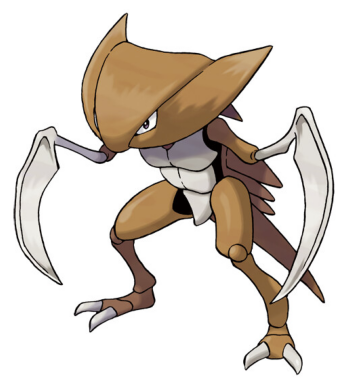

In [ ]:
image_path = "/kaggle/input/hbbhjnjnj/kabutops.jpg"
caption = generate(image_path)
plt.imshow(Image.open(image_path))
plt.axis("off")
print(f"Generated Caption: {caption}")

<h3><b>Evaluating the model on metrics such as Cider as well as Rouge score

In [ ]:
from pycocoevalcap.cider.cider import Cider

generated = []
references = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
with torch.no_grad():
    for i in tqdm(range(100)):
        item = val_dataset[i]
        pixel_values = item["pixel_values"].unsqueeze(0).to(device)
        output_ids = model.generate(pixel_values, max_length=30)
        generated_caption = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        reference_caption = processor.tokenizer.decode(item["input_ids"], skip_special_tokens=True)

        generated.append(generated_caption)
        references.append([reference_caption])

candidates = {i: [generated[i]] for i in range(len(generated))}
references_dict = {i: references[i] for i in range(len(references))}

cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(references_dict, candidates)

print("CIDER Score:", cider_score)

100%|██████████| 100/100 [00:28<00:00,  3.48it/s]

CIDEr Score: 2.785385344134675


<h3><b>Evaluating the model by calculating its rouge score

In [ ]:
import evaluate
rouge = evaluate.load("rouge")

predictions = []
references = []
model.eval()
with torch.no_grad():
    for i in tqdm(range(100)):
        item = val_dataset[i]
        pixel_values = item["pixel_values"].unsqueeze(0).to(device)
        output_ids = model.generate(pixel_values, max_length=30)

        generated_caption = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        reference_caption = processor.tokenizer.decode(item["input_ids"], skip_special_tokens=True)

        predictions.append(generated_caption)
        references.append(reference_caption)

rouge_score = rouge.compute(predictions=predictions, references=references)
print("ROUGE Scores:", rouge_score)

100%|██████████| 100/100 [00:29<00:00,  3.44it/s]

ROUGE Scores: {'rouge1': 0.6031616729279601, 'rouge2': 0.4347259587247976, 'rougeL': 0.5843569017337187, 'rougeLsum': 0.5863991219329421}
